# GPCP ISOMAP, remove annual cycle

In [1]:
from netCDF4 import Dataset
import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import pygrib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from sklearn.manifold import Isomap

In [2]:
ncfile = Dataset('data.nc')
# print(ncfile)

tmp = ncfile.variables['precip'].valid_range
# print(tmp,type(tmp))

# ncfile.variables['precip'].valid_range = [0.0,100.0]

data_ori = ncfile.variables['precip'][:]
data = data_ori.reshape(data_ori.shape[0],-1)
print(ncfile.variables['precip'])

print(data.shape)

<class 'netCDF4._netCDF4.Variable'>
float32 precip(T, Y, X)
    pointwidth: 1.0
    units: mm/day
    valid_range: [  0. 100.]
    long_name: NOAA Climate Data Record (CDR) of GPCP Satellite-Gauge Combined Precipitation
    coordinates: longitude latitude time
    missing_value: -9999.0
    cell_methods: precip: mean
    expires: 1651708800
    standard_name: lwe_precipitation_rate
unlimited dimensions: 
current shape = (517, 72, 144)
filling on, default _FillValue of 9.969209968386869e+36 used
(517, 10368)


In [3]:
T = ncfile.variables['T'][:]
print(ncfile.variables['T'])

<class 'netCDF4._netCDF4.Variable'>
float32 T(T)
    long_name: Time
    pointwidth: 1.0
    standard_name: time
    calendar: 360
    expires: 1651708800
    gridtype: 0
    units: months since 1960-01-01
unlimited dimensions: 
current shape = (517,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [4]:
init_date = datetime.date(1960,1,1)
data_time = np.array([init_date + relativedelta(months=int(i)) for i in T])
print(data_time)
dd = data_time[144:504]
dd_str = [happy.strftime("%Y%m") for happy in dd]
print(dd_str)

[datetime.date(1979, 1, 1) datetime.date(1979, 2, 1)
 datetime.date(1979, 3, 1) datetime.date(1979, 4, 1)
 datetime.date(1979, 5, 1) datetime.date(1979, 6, 1)
 datetime.date(1979, 7, 1) datetime.date(1979, 8, 1)
 datetime.date(1979, 9, 1) datetime.date(1979, 10, 1)
 datetime.date(1979, 11, 1) datetime.date(1979, 12, 1)
 datetime.date(1980, 1, 1) datetime.date(1980, 2, 1)
 datetime.date(1980, 3, 1) datetime.date(1980, 4, 1)
 datetime.date(1980, 5, 1) datetime.date(1980, 6, 1)
 datetime.date(1980, 7, 1) datetime.date(1980, 8, 1)
 datetime.date(1980, 9, 1) datetime.date(1980, 10, 1)
 datetime.date(1980, 11, 1) datetime.date(1980, 12, 1)
 datetime.date(1981, 1, 1) datetime.date(1981, 2, 1)
 datetime.date(1981, 3, 1) datetime.date(1981, 4, 1)
 datetime.date(1981, 5, 1) datetime.date(1981, 6, 1)
 datetime.date(1981, 7, 1) datetime.date(1981, 8, 1)
 datetime.date(1981, 9, 1) datetime.date(1981, 10, 1)
 datetime.date(1981, 11, 1) datetime.date(1981, 12, 1)
 datetime.date(1982, 1, 1) datetime.d

In [5]:
X = ncfile.variables['X'][:]
Y = ncfile.variables['Y'][:]
print(X.shape,Y.shape)
lons, lats = np.meshgrid(X, Y)
print(lats.shape)

(144,) (72,)
(72, 144)


In [6]:
colors = np.loadtxt('/work2/mbntsai/project/pic_tools/color/precip_cwb.rgb')
print(colors,colors.shape)
cmap = ListedColormap(np.array(colors[2:-1,:])/255).with_extremes(under=np.array(colors[0,:])/255,over=np.array(colors[-1,:])/255)
contourn=[0,1.0,2.0,6.0,10.0,15.0,20.0,30.0,40.0,50.0,70.0,90.0,110.0,130.0,150.0,200.0,300.0]
norm = BoundaryNorm(contourn, cmap.N)

[[255. 255. 255.]
 [  0.   0.   0.]
 [193. 193. 193.]
 [155. 255. 255.]
 [  0. 207. 255.]
 [  1. 152. 255.]
 [  1. 101. 255.]
 [ 48. 153.   1.]
 [ 50. 255.   0.]
 [248. 255.   0.]
 [255. 203.   0.]
 [255. 154.   0.]
 [250.   3.   0.]
 [204.   0.   3.]
 [160.   0.   0.]
 [152.   0. 154.]
 [195.   4. 204.]
 [248.   5. 243.]
 [254. 203. 255.]] (19, 3)


## remove annual cycle

In [7]:
X_mean = np.zeros([12,72*144])
i=0
for arr in data[144:504]:
    if(i==12): i=0
    X_mean[i,:] = X_mean[i,:] + arr
    i=i+1
X_mean = X_mean/30
X_variation = np.copy(data[144:504])
i=0
for iarr in range(len(X_variation)):
    if(i==12): i=0
    X_variation[iarr,:] = X_variation[iarr,:] - X_mean[i,:]
    i=i+1

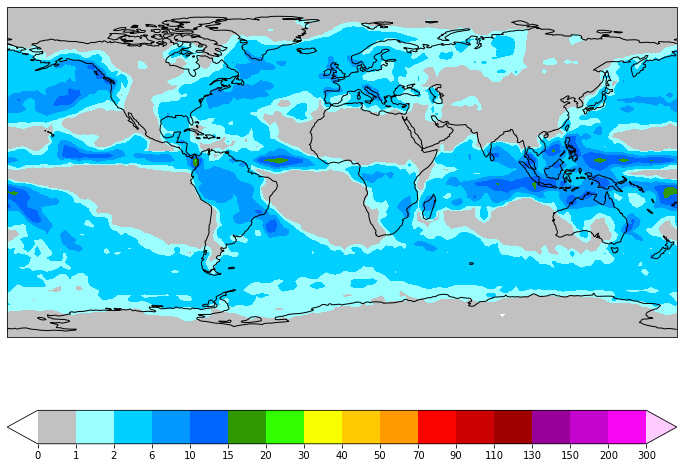

In [8]:
fig, ax = plt.subplots(figsize=(12,9), subplot_kw={'projection': ccrs.PlateCarree()})
happy = data[503].reshape(72,144)
happy, lonnn = add_cyclic_point(happy, coord=X)
pcm = ax.contourf(lonnn, Y, happy,cmap=cmap,norm=norm,levels=contourn,extend="both")
ax.coastlines()
fig.colorbar(pcm, ax=ax,ticks=contourn,extend="both", orientation="horizontal")
plt.show()

In [9]:
data_all = data.reshape(data.shape[0],-1)

In [10]:
data_all.shape

(517, 10368)

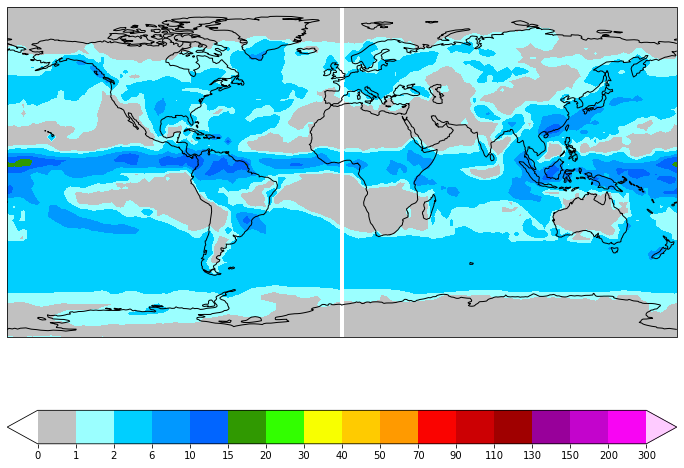

In [11]:
fig, ax = plt.subplots(figsize=(12,9), subplot_kw={'projection': ccrs.PlateCarree()})
pcm = ax.contourf(lons, lats, data_all[100].reshape(72,144),cmap=cmap,norm=norm,levels=contourn,extend="both")
ax.coastlines()
fig.colorbar(pcm, ax=ax,ticks=contourn,extend="both", orientation="horizontal")
plt.show()

In [12]:
oni = pd.read_csv('/work2/mbntsai/TWAI/code/sst_eof/oni').iloc[-374:-14,3].to_numpy()
oni_id = np.zeros(len(oni))
oni_id[oni>=0.5]=1
oni_id[oni<=-0.5]=-1

In [13]:
# oni_color = np.chararray(len(oni), itemsize=5)
# oni_color[:] = 'gray'
# oni_color[oni>=0.5]='r'
# oni_color[oni<=-0.5]='b'
# oni_color.tolist()

In [14]:
pd.read_csv('/work2/mbntsai/TWAI/code/sst_eof/oni').iloc[-518:-1,:]

,SEAS,YR,TOTAL,ANOM
348,DJF,1979,26.50,0.03
349,JFM,1979,26.75,0.07
350,FMA,1979,27.22,0.20
351,MAM,1979,27.60,0.28
352,AMJ,1979,27.66,0.23
...,...,...,...,...
860,ASO,2021,26.09,-0.67
861,SON,2021,25.90,-0.81
862,OND,2021,25.69,-0.98
863,NDJ,2021,25.63,-0.99


In [15]:
k=44
isomap_model = Isomap(n_components=5, n_neighbors=k)
isomap_result = isomap_model.fit_transform(X_variation)

In [16]:
print(isomap_result[:,0].min(),isomap_result[:,0].max())
print(isomap_result[:,1].min(),isomap_result[:,1].max())
print(isomap_result[:,2].min(),isomap_result[:,2].max())

-258.7214019299491 260.5508954420993
-166.23899332997246 167.8817289602572
-166.61112413857774 179.01971514492965


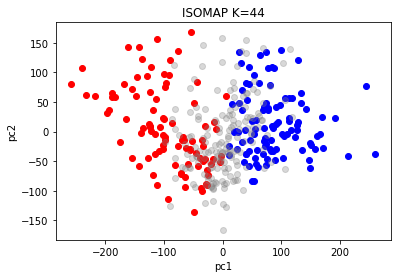

In [17]:
fig, ax = plt.subplots()
ax.scatter(isomap_result[oni>=0.5,0],isomap_result[oni>=0.5,1], c='red')
ax.scatter(isomap_result[oni<=-0.5,0],isomap_result[oni<=-0.5,1], c='blue')
ax.scatter(isomap_result[oni_id==0,0],isomap_result[oni_id==0,1],color=[0.5,0.5,0.5],alpha=0.3)
ax.set_xlabel(f'pc1')
ax.set_ylabel(f'pc2')
ax.set_title(f'ISOMAP K={k}')
plt.show()

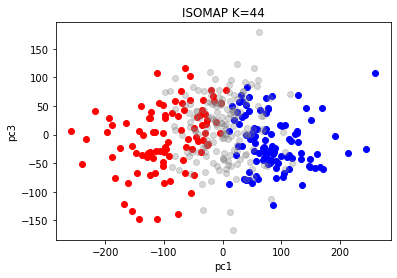

In [18]:
fig, ax = plt.subplots()
ax.scatter(isomap_result[oni>=0.5,0],isomap_result[oni>=0.5,2], c='red')
ax.scatter(isomap_result[oni<=-0.5,0],isomap_result[oni<=-0.5,2], c='blue')
ax.scatter(isomap_result[oni_id==0,0],isomap_result[oni_id==0,2],color=[0.5,0.5,0.5],alpha=0.3)
ax.set_xlabel(f'pc1')
ax.set_ylabel(f'pc3')
ax.set_title(f'ISOMAP K={k}')
plt.show()

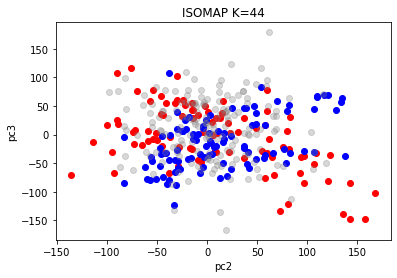

In [19]:
fig, ax = plt.subplots()
ax.scatter(isomap_result[oni>=0.5,1],isomap_result[oni>=0.5,2], c='red')
ax.scatter(isomap_result[oni<=-0.5,1],isomap_result[oni<=-0.5,2], c='blue')
ax.scatter(isomap_result[oni_id==0,0],isomap_result[oni_id==0,2],color=[0.5,0.5,0.5],alpha=0.3)
ax.set_xlabel(f'pc2')
ax.set_ylabel(f'pc3')
ax.set_title(f'ISOMAP K={k}')
plt.show()

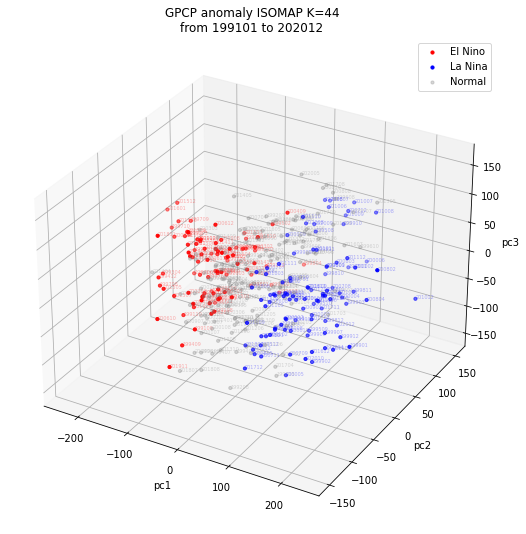

In [20]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(projection='3d')
ax.set_xlim(isomap_result[:,0].min(),isomap_result[:,0].max())
ax.set_ylim(isomap_result[:,1].min(),isomap_result[:,1].max())
ax.set_zlim(isomap_result[:,2].min(),isomap_result[:,2].max())
ax.scatter(isomap_result[oni>=0.5,0],isomap_result[oni>=0.5,1],isomap_result[oni>=0.5,2],color=[1,0,0],label='El Nino',s=10)
ax.scatter(isomap_result[oni<=-0.5,0],isomap_result[oni<=-0.5,1],isomap_result[oni<=-0.5,2],color=[0,0,1],label='La Nina',s=10)
ax.scatter(isomap_result[oni_id==0,0],isomap_result[oni_id==0,1],isomap_result[oni_id==0,2],color=[0.5,0.5,0.5],label='Normal',alpha=0.3,s=10)
for i, txt in enumerate(dd_str):
    color = [0.5,0.5,0.5]
    if(oni[i]>=0.5): color = [1,0,0]
    if(oni[i]<=-0.5): color = [0,0,1]
    ax.text(isomap_result[i,0], isomap_result[i,1], isomap_result[i,2], txt, color=color, size=5, alpha=0.3)
ax.set_xlabel(f'pc1')
ax.set_ylabel(f'pc2')
ax.set_zlabel(f'pc3')
ax.set_title(f'GPCP anomaly ISOMAP K={k}\nfrom 199101 to 202012')
ax.legend(loc='upper right')
# ax.view_init(elev=20, azim=280)
# plt.show()
fig.savefig('gpcp_anomaly_isomap.svg')

In [21]:
# for nn in range(1,len(isomap_result)):
#     fig = plt.figure(figsize=(12,9))
#     ax = fig.add_subplot(projection='3d')
#     ax.set_xlim(-300,300)
#     ax.set_ylim(-200,200)
#     ax.set_zlim(-200,200)
#     # for i in range(1,nn):
#     #     alpha = i/nn
#     for i in range(max(1,nn-24),nn):
#         alpha = (i-nn+24)/24
#         color = [0.5,0.5,0.5]
#         if(oni[i]>=0.5): color = [1,0,0]
#         if(oni[i]<=-0.5): color = [0,0,1]
#         ax.plot3D(isomap_result[i-1:i+1,0],isomap_result[i-1:i+1,1],isomap_result[i-1:i+1,2], color=[0.5,0.5,0.5], alpha=alpha)
#         ax.scatter3D(isomap_result[i,0],isomap_result[i,1],isomap_result[i,2], color=color, alpha=alpha)
#         # ax.text(isomap_result[i,0], isomap_result[i,1], isomap_result[i,2], dd_str[i], color=color, size=5, alpha=alpha)
#         ax.set_xlabel(f'pc1')
#         ax.set_ylabel(f'pc2')
#         ax.set_zlabel(f'pc3')
#         ax.set_title(f'GPCP anomaly ISOMAP K={k}\nTime: {dd_str[i]}')
#         # fig.text(s=f'lon:{lon1}~{lon2}, lat:{lat1}~{lat2} ', x=0.5, y=0, fontsize=10, ha='center', va='center')
#     fig.savefig(f'./jpg_isomap_gpcp_anomaly/isomap{nn:03d}.jpg',dpi=150)
#     plt.close(fig)

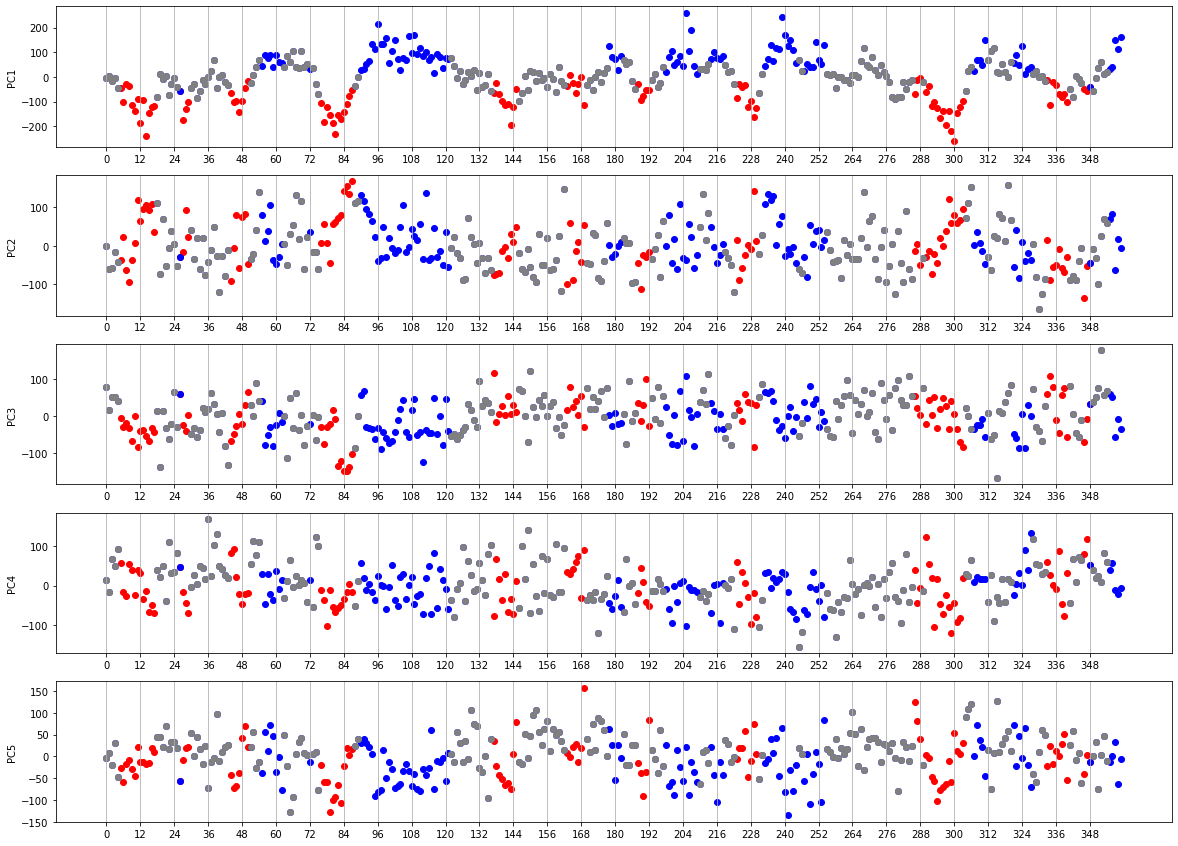

In [22]:
n=5
fig, ax = plt.subplots(n,1,figsize=(20,3*n))
for i in range(n):
    ax[i].scatter(np.arange(len(oni))[oni>=0.5],isomap_result[oni>=0.5,i],color='r')
    ax[i].scatter(np.arange(len(oni))[oni<=0.5],isomap_result[oni<=0.5,i],color='b')
    ax[i].scatter(np.arange(len(oni))[oni_id==0],isomap_result[oni_id==0,i],color='gray')
    ax[i].set_xticks(np.arange(0,len(isomap_result),12))
    ax[i].set_ylabel(f'PC{i+1}')
    ax[i].grid(axis='x')
plt.show()

## Asian domain

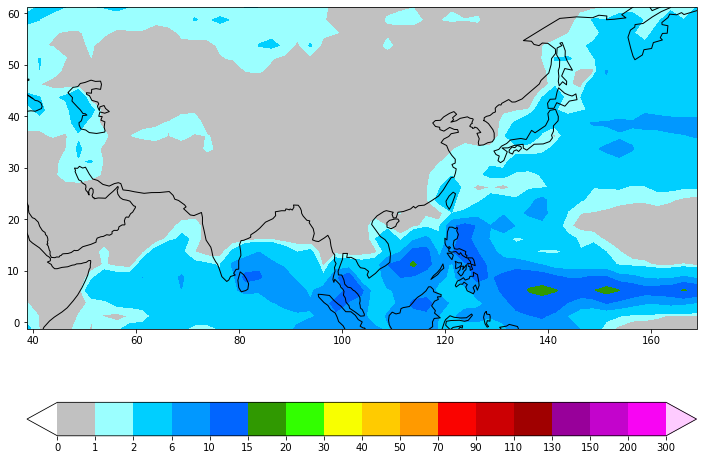

In [23]:
xx1 = 15
xx2 = 68
yy1 = 11
yy2 = 37

tmp = X_variation.reshape(X_variation.shape[0],72,144)
happy = tmp[:,yy1:yy2,xx1:xx2].reshape(tmp[:,yy1:yy2,xx1:xx2].shape[0],-1)

tmp = X_mean.reshape(X_mean.shape[0],72,144)
happy_mean = tmp[:,yy1:yy2,xx1:xx2].reshape(tmp[:,yy1:yy2,xx1:xx2].shape[0],-1)

fig, ax = plt.subplots(figsize=(12,9), subplot_kw={'projection': ccrs.PlateCarree()})
pcm = ax.contourf(lons[yy1:yy2,xx1:xx2], lats[yy1:yy2,xx1:xx2], happy[-1].reshape(yy2-yy1,xx2-xx1)+happy_mean[-1].reshape(yy2-yy1,xx2-xx1),cmap=cmap,norm=norm,levels=contourn,extend="both")
ax.coastlines()
ax.set_xticks([40,60,80,100,120,140,160], crs=ccrs.PlateCarree())
ax.set_yticks([0,10,20,30,40,50,60], crs=ccrs.PlateCarree())
fig.colorbar(pcm, ax=ax,ticks=contourn,extend="both", orientation="horizontal")
plt.show()

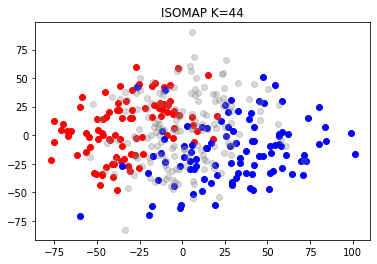

In [24]:
k=44
isomap_model = Isomap(n_components=3, n_neighbors=k)
isomap_result = isomap_model.fit_transform(happy)

fig, ax = plt.subplots()
ax.scatter(isomap_result[oni>=0.5,0],isomap_result[oni>=0.5,1], c='red')
ax.scatter(isomap_result[oni<=-0.5,0],isomap_result[oni<=-0.5,1], c='blue')
ax.scatter(isomap_result[oni_id==0,0],isomap_result[oni_id==0,1],color=[0.5,0.5,0.5],alpha=0.3)
ax.set_title(f'ISOMAP K={k}')
plt.show()

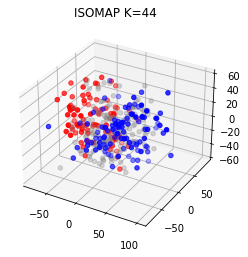

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(isomap_result[oni>=0.5,0],isomap_result[oni>=0.5,1],isomap_result[oni>=0.5,2],color=[1,0,0])
ax.scatter(isomap_result[oni<=-0.5,0],isomap_result[oni<=-0.5,1],isomap_result[oni<=-0.5,2],color=[0,0,1])
ax.scatter(isomap_result[oni_id==0,0],isomap_result[oni_id==0,1],isomap_result[oni_id==0,2],color=[0.5,0.5,0.5],alpha=0.3)
ax.set_title(f'ISOMAP K={k}')
plt.show()